# Experiment One

The first study, called `experiment-one`, looked at the effect of social influence on curiousity, using upvotes as proxy for social interest. Below we analyze the responses to test the hypothesis that the same questions, when given higher upvotes, receive higher scores from participants with regards to curiousity. And, further, whether this translates into participants being more likely to choose to view the answers to the questions with higher upvotes.

## Analysis

In [2]:
%load_ext pycodestyle_magic

In [3]:
# Analytical Tools
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# General Utilities
import math
import json
import pprint
import itertools
import importlib

# Custom Utilities
import utilities.processing as processing
import utilities.plotting as plotting
import utilities.describe as describe

# Some settings
log = pprint.pprint
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Reading Data and Defining Constants

In [4]:
FILE_NAMES = [
    'raw-data/questions-and-answers-clean.json',
    'raw-data/judgments.json',
    'raw-data/responses.json'
]

LITERALS = []
NUM_QUESTIONS, NUM_JUDGEMENTS = 10, 7
LOW_LABELS, HIGH_LABELS = processing.get_split_labels(NUM_QUESTIONS)
JUDGMENT_LABELS = ['j{}'.format(num) for num in range(NUM_JUDGEMENTS)]

for name in FILE_NAMES[:2]:
    with open(name) as file:
         LITERALS.append(json.load(file))
with open(FILE_NAMES[2]) as file:
    master_responses = [json.loads(line) for line in file if line]

### Reading Responses into Data
Creates a `DataFrame` based on the survey data.

In [5]:
col_labels = processing.get_col_labels(NUM_QUESTIONS,
                                       NUM_JUDGEMENTS)
data = {label: [] for label in col_labels}

In [6]:
processing.fill_experiment_three_data(data, master_responses)

In [7]:
data = pd.DataFrame(data)
data = data[data.consent == 1]
print(data.size, len(data))
data.head()

30401 301


,consent,high_q0_choice,high_q0_index,high_q0_j0,high_q0_j1,high_q0_j2,high_q0_j3,high_q0_j4,high_q0_j5,high_q0_j6,...,low_q4_choice,low_q4_index,low_q4_j0,low_q4_j1,low_q4_j2,low_q4_j3,low_q4_j4,low_q4_j5,low_q4_j6,low_q4_score
0,1,1,38,3,3,2,1,3,4,2,...,0,12,4,3,4,2,3,3,1,31
1,1,0,21,3,3,3,3,3,3,4,...,1,10,3,3,3,3,3,4,3,33
2,1,1,31,4,1,3,3,5,2,2,...,1,0,2,2,3,3,3,1,2,22
3,1,0,41,4,4,1,4,4,3,2,...,1,15,2,1,4,4,1,3,3,18
4,1,1,37,3,3,4,4,3,1,2,...,0,18,3,4,4,3,3,2,3,30


### Paired Samples T-Test
We first attempt to replicate the results of the first experiment by once again conducting a paired samples t-test.

In [8]:
# Update the table with intermediate values
low_means, low_err = [], []
high_means, high_err = [], []
sample_size = len(data)

for j_label in JUDGMENT_LABELS:
    low_headers = ['{}_{}'.format(q_label, j_label) for q_label in LOW_LABELS]
    high_headers = ['{}_{}'.format(q_label, j_label) for q_label in HIGH_LABELS]
    low_data = data[low_headers].mean(axis=1)
    high_data = data[high_headers].mean(axis=1)
    
    data['{}_low'.format(j_label)] = low_data
    data['{}_high'.format(j_label)] = high_data
    data['{}_diff'.format(j_label)] = high_data - low_data
    
    low_means.append(low_data.mean())
    low_err.append(low_data.std() / math.sqrt(sample_size))
    high_means.append(high_data.mean())
    high_err.append(high_data.std() / math.sqrt(sample_size))

Curiosity: t = -6.7, p = 1.03e-10 (1 greater)
Confidence: t = 0.0618, p = 0.951 (0 greater)
Usefulness: t = -4.85, p = 1.95e-06 (1 greater)
Popularity: t = -22.3, p = 1.42e-65 (1 greater)
Writing: t = -5.55, p = 6.2e-08 (1 greater)
Surprise: t = -6.45, p = 4.37e-10 (1 greater)
Social Utility: t = -6.37, p = 7.21e-10 (1 greater)


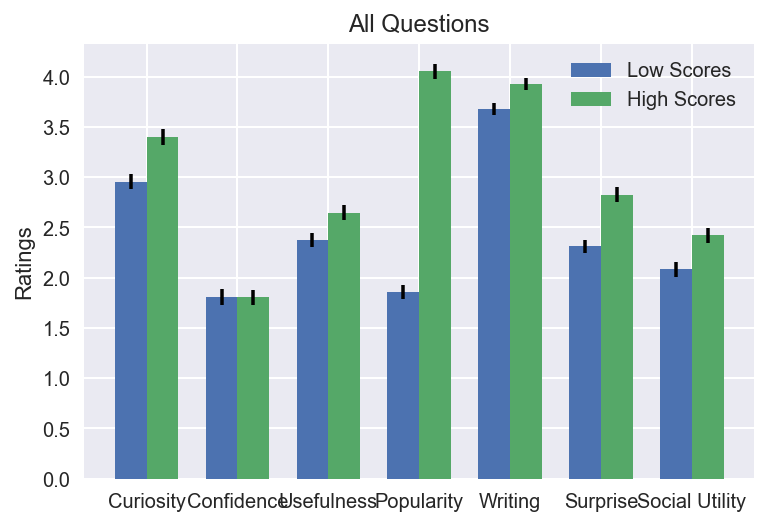

In [9]:
# Compute averages, run t-test and plot
PLOTTING_OPTIONS = {
    'y_label': 'Ratings',
    'ticks': ['Curiosity', 'Confidence', 'Usefulness',
              'Popularity', 'Writing', 'Surprise', 'Social Utility'],
    'legend': ['Low Scores', 'High Scores'],
    'title': 'All Questions'
}

for index, j_label in enumerate(JUDGMENT_LABELS):
    low_data = data['{}_low'.format(j_label)]
    high_data = data['{}_high'.format(j_label)]
    print('{}: {}'.format(PLOTTING_OPTIONS['ticks'][index],
                          describe.paired_t_test(low_data, high_data)))

plotting.plot_double_bar(low_means, low_err, high_means,
                         high_err, **PLOTTING_OPTIONS)

In [15]:
low_choice_labels = ['{}_choice'.format(q_label) for q_label in LOW_LABELS]
high_choice_labels = ['{}_choice'.format(q_label) for q_label in HIGH_LABELS]
low_choice_means = data[low_choice_labels].mean(axis=1)
high_choice_means = data[high_choice_labels].mean(axis=1)

print(describe.one_sample_t_test(high_choice_means, 0.5))

t = 4.25, p = 2.87e-05 (greater)
